# Perceived Dependence of Stocks and Correlation: Monthly Fama and MachBeth Regressions

For my thesis, i will look into the difference between the perceived dependence and the actual correlation of the return of stocks with the market return. In this notebook, we will try to import the data we have processed (in this notebook, on a monthly basis) and do some statistical tests on them.

In [3]:
# Note that all of the returns and factors are in decimal and monthly forms. In the final results, one could convert to yearly percentages
# by multiplying with 12 * 100.

## 0. Imports

Let's import some needed libs first.

In [199]:
# Data manipulation
import pandas as pd
import numpy as np

# Statistical modeling
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from scipy.stats import spearmanr
from sklearn.utils import resample
from scipy import stats


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from matplotlib.dates import DateFormatter

# Date handling
from datetime import datetime

# Excel handling
import openpyxl

import warnings

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now, we can read the Excel file that we created when running the notebook Data_Monthly. This notebook has prepared our data for the analysis.

In [5]:
# Open the Excel workbook
wb = openpyxl.load_workbook('Data_Monthly.xlsx', data_only=True)

# Dictionary to hold the monthly dataframes
dfs = {}

# Define the start and end dates
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)  # DEBUG

# Generate the monthly periods
monthly_periods = pd.date_range(start_date, end_date, freq='M')

for period in monthly_periods:
    # Extract the year and month
    year = period.year
    month = period.month

    # Format the worksheet name as MMYYYY
    df_name = f"{month:02d}{year}"

    # Find the correct worksheet
    try:
        ws = wb[df_name]

        # Read worksheet into a DataFrame
        data = ws.values
        columns = next(data)[0:]  # Get the first row as column names
        df = pd.DataFrame(data, columns=columns)

        df['Comove'] = df['Comove']/ 100 #kwni of da moet
        df['Min'] = df['Min'] * -1

        # Store the DataFrame in the dictionary
        dfs[df_name] = df

    except KeyError:
        print(f"Worksheet {df_name} not found in the workbook.")
    except Exception as e:
        print(f"Failed to read worksheet {df_name}: {e}")

# No need to explicitly close the workbook

Worksheet 032024 not found in the workbook.


In [32]:
dfs["012002"]

,Name,Comove,Beta,Return,Size,Value,Momentum,Beta_Downside,Beta_Upside,LTD,...,Exchange_CP,Size_1,Size_2,Size_3,Size_4,Size_5,Comove_skippedMonth,Comove_Monthly,Comove_Daily,Comove_EUR50
0,3I GROUP - TOT RETURN IND,0.471698,1.405906,-0.001050,15.942634,7.350835,-0.002846,0.701934,0.898882,0.673852,...,False,False,False,False,True,False,50.000000,41.666667,76.628352,47.169811
1,ABB LTD N - TOT RETURN IND,0.603774,1.675130,-0.000753,16.281342,9.129183,-0.005789,0.757205,1.305786,0.691230,...,False,False,False,False,True,False,62.500000,50.000000,73.946360,60.377358
2,ABBEY NATIONAL DEAD - T/O SEE 702853 - TOT RET...,0.471698,1.091207,0.000627,14.868929,NaN,-0.001574,0.780586,0.462556,0.627102,...,False,False,True,False,False,False,45.833333,44.444444,67.432950,47.169811
3,ABN AMRO HOLDING DEAD - 25/04/08 - TOT RETURN IND,0.547170,1.317305,0.001128,17.139726,NaN,-0.002157,1.022924,0.820010,0.714905,...,False,False,False,False,False,True,54.166667,44.444444,74.712644,54.716981
4,ACCOR - TOT RETURN IND,0.433962,1.041479,0.000042,15.901995,7.619709,-0.001511,0.571503,0.720720,0.481350,...,False,False,False,False,True,False,45.833333,41.666667,67.049808,43.396226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,XANSA DEAD - EX.INTO 672558 - TOT RETURN IND,0.490566,1.071944,-0.001526,14.057303,NaN,0.002329,0.399560,0.754931,0.373160,...,False,True,False,False,False,False,50.000000,55.555556,60.919540,49.056604
596,ZARDOYA OTIS DEAD - DELIST.09/05/22 - TOT RETU...,0.490566,0.087733,0.000509,14.373579,9.715478,0.002704,0.068495,-0.001327,0.002672,...,False,True,False,False,False,False,47.916667,41.666667,55.938697,49.056604
597,PHARMA MAR - TOT RETURN IND,0.547170,1.162064,0.000297,14.332686,9.083000,-0.002678,1.024095,0.322143,0.429751,...,False,True,False,False,False,False,50.000000,38.888889,67.049808,54.716981
598,ZODIAC AEROSPACE DEAD - DELIST.23/03/18 - TOT ...,0.509434,0.862112,0.000966,14.052433,7.770517,-0.003197,0.528681,0.550953,0.412155,...,False,True,False,False,False,False,54.166667,47.222222,62.452107,50.943396


##  1. Data Knowledge

### 1.1 Univariate Distributions

In [103]:
# For the following variables: 'Comove'  'Beta' 'Beta_Downside	'Beta_Upside', 'LTD', 'UTD'
# Make a dataframe with the following statistics:  Mean Median Std. Dev. p10 p90  N
# Make a plot with monthly averages over time per variable, all variables in one plot, in the same style as before
# Make a correlation heatmap with values in it, in the same style as before

In [104]:
# Assuming dfs is a dictionary with your dataframes
# Merge all dataframes into one for analysis
all_data = pd.concat(dfs.values())

# Define the variables
variables = ['Comove', 'Return', 'Size', 'Value', 'Momentum', 'Beta', 'Beta_Downside', 'Beta_Upside', 'LTD', 'UTD', 'IdioVol', 'Min', 'Max']

# Create a DataFrame with the required summary statistics
summary_stats = pd.DataFrame({
    'Mean': all_data[variables].mean(),
    'Median': all_data[variables].median(),
    'Std. Dev.': all_data[variables].std(),
    'p10': all_data[variables].quantile(0.10),
    'p90': all_data[variables].quantile(0.90),
    'N': all_data[variables].count()
})

print("Summary Statistics:")
summary_stats

Summary Statistics:


,Mean,Median,Std. Dev.,p10,p90,N
Comove,0.516480,0.519231,0.093607,0.396226,0.634615,159606
Return,0.006603,0.007291,0.094009,-0.095059,0.105630,159579
Size,15.777196,15.635477,1.128648,14.425383,17.381946,157586
Value,7.717266,7.668255,0.803395,6.788161,8.725466,147372
Momentum,0.111231,0.091862,0.368912,-0.290936,0.497037,158016
Beta,0.991530,0.963530,0.408357,0.494960,1.517197,159571
Beta_Downside,0.554965,0.527823,0.302893,0.195106,0.944729,159569
Beta_Upside,0.531335,0.491382,0.351411,0.154820,0.963091,159568
LTD,0.540189,0.575157,0.177964,0.283765,0.739755,159606
UTD,0.456998,0.468711,0.132204,0.277979,0.619529,159571


In [105]:
# Perhaps i need to check beta upside downside and ltd utd since i get totally different means. same for value. perhaps with idiovol gedeeld door 100 ma rest weet ik zo nie, effe checken

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.2 Correlations

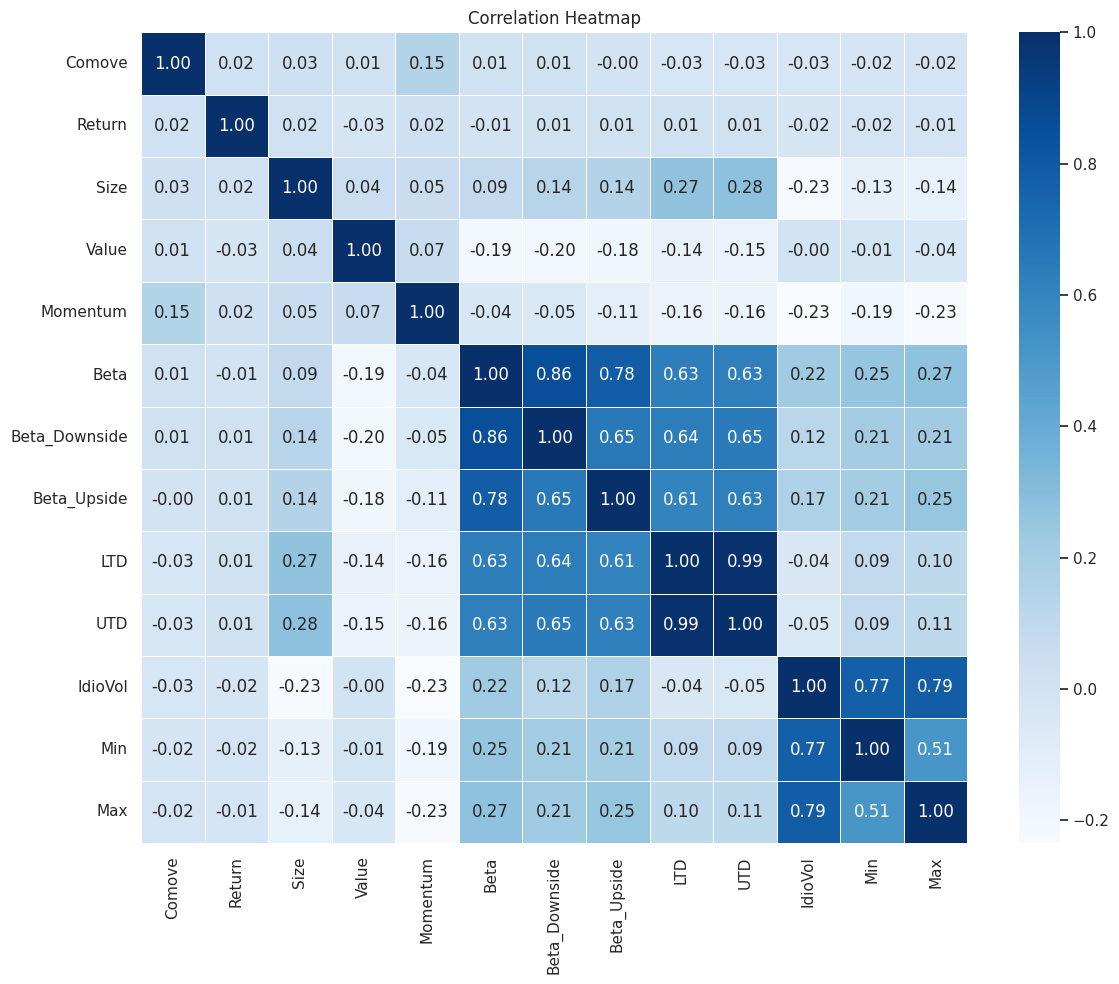

In [106]:
# Calculate correlation matrix
correlation_matrix = all_data[variables].corr()

# Create a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('Correlation_Heatmap.png')
plt.show()

### 1.3 Plots

In [107]:
all_data = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
# Define the variables
variables = ['Comove',  'Beta', 'Beta_Downside', 'Beta_Upside', 'LTD', 'UTD', 'IdioVol', 'Min', 'Max', 'Illiquidity', 'Ln(Turnover)', 'Diff in Ln(Turnover)']

# Assuming dfs is a dictionary where keys are month-year strings and values are dataframes
# Initialize an empty DataFrame to store the monthly averages
monthly_averages_list = []

# Loop through each dataframe in the dictionary and calculate the averages
for month, df in dfs.items():
  df = df.loc[:, variables]
  avg = df.mean(numeric_only=True)
  avg['MMYYYY'] = month
  monthly_averages_list.append(avg)

# Combine the list of series into a DataFrame
monthly_averages = pd.DataFrame(monthly_averages_list)

# Convert 'MMYYYY' to a proper date format
monthly_averages['MMYYYY'] = pd.to_datetime(monthly_averages['MMYYYY'], format='%m%Y')
monthly_averages.set_index('MMYYYY', inplace=True)

print("Monthly Averages:")
monthly_averages[variables]

Monthly Averages:


,Comove,Beta,Beta_Downside,Beta_Upside,LTD,UTD,IdioVol,Min,Max,Illiquidity,Ln(Turnover),Diff in Ln(Turnover)
MMYYYY,,,,,,,,,,,,
2002-01-01,0.500786,0.816892,0.407353,0.472765,0.375597,0.342738,1.690291,0.000371,0.000485,NaN,17.009239,0.003116
2002-02-01,0.507013,0.811481,0.409173,0.473315,0.390914,0.353235,1.706052,0.000386,0.000422,NaN,16.567255,-0.462692
2002-03-01,0.500786,0.815615,0.409296,0.475258,0.401859,0.360152,1.759694,0.000403,0.000404,NaN,16.909392,0.342137
2002-04-01,0.482596,0.813126,0.409113,0.489990,0.388093,0.350499,1.668061,0.033141,0.043736,NaN,16.833996,-0.094425
2002-05-01,0.499591,0.804550,0.411641,0.482602,0.379081,0.344084,1.573455,0.036994,0.035856,NaN,16.891512,0.057517
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,0.552244,1.144911,0.562214,0.618720,0.531832,0.447003,1.313026,0.033209,0.029787,0.000001,16.369097,-0.037474
2023-11-01,0.523742,1.123264,0.554637,0.567702,0.524165,0.440485,1.570539,0.043723,0.036238,0.000001,16.470009,0.100912
2023-12-01,0.531006,1.120691,0.560211,0.533804,0.524186,0.440190,1.436043,0.030525,0.043324,0.000001,16.546870,0.073916


In [109]:
# Normalize the monthly averages to have mean 0 and standard deviation 1
normalized_averages = (monthly_averages[variables] - monthly_averages[variables].mean()) / monthly_averages[variables].std()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.3.1 Assymetric

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


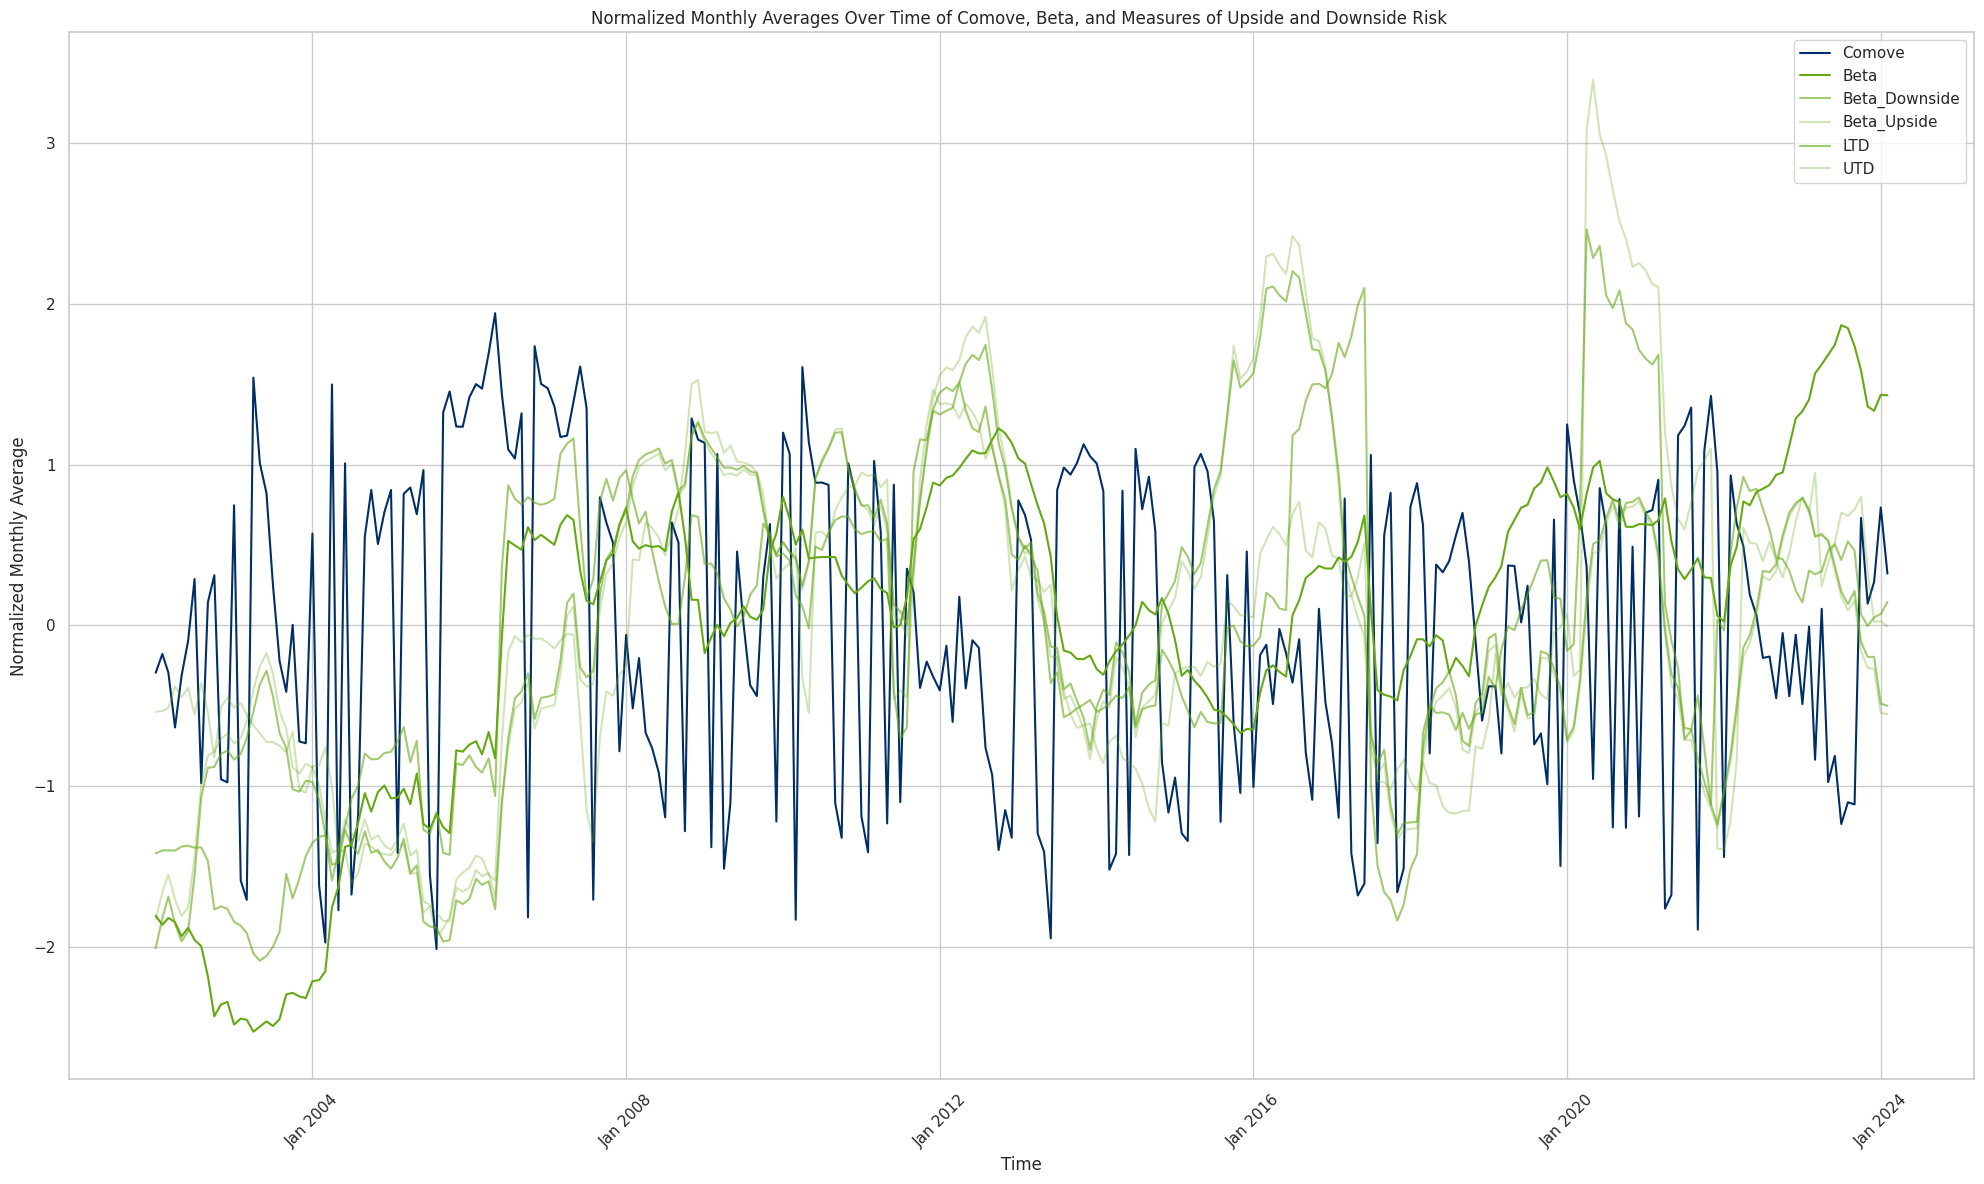

In [110]:
# Define the variables
variables = ['Comove',  'Beta', 'Beta_Downside', 'Beta_Upside', 'LTD', 'UTD']

# Set the style
sns.set(style="whitegrid")

# Plot normalized monthly averages over time for each variable
plt.figure(figsize=(20, 12))

# Define colors and line styles
# Define colors and line styles
colors = {
    'Comove': '#002E65',  # Blue
    'Beta': '#65A812',  # Green
    'Beta_Downside': '#65A81280',  # Lighter green (transparent)
    'Beta_Upside': '#65A81240',  # Even lighter green (more transparent)
    'LTD': '#65A81280',  # Lighter green (transparent)
    'UTD': '#65A81240',  # Even lighter green (more transparent)
    'IdioVol': '#808080',  # Grey
    'Min': '#B0B0B0',  # Lighter grey
    'Max': '#D0D0D0',  # Even lighter grey
    'Illiquidity': '#006400',  # Dark Green
    'L(Turnover)': '#000000',  # Black
    'Diff in Ln(Turnover)': '#404040'  # Dark grey (almost black)
}

line_styles = {
    'Comove': {'linewidth': 1.5},
    'Beta': {'linewidth': 1.5},
    'Beta_Downside': {'linewidth': 1.5, 'alpha': 0.6},
    'Beta_Upside': {'linewidth': 1.5, 'alpha': 0.3},
    'LTD': {'linewidth': 1.5, 'alpha': 0.6},
    'UTD': {'linewidth': 1.5, 'alpha': 0.3},
    'IdioVol': {'linewidth': 1.5},
    'Min': {'linewidth': 1.5, 'alpha': 0.6},
    'Max': {'linewidth': 1.5, 'alpha': 0.3},
    'Illiquidity': {'linewidth': 1.5},
    'L(Turnover)': {'linewidth': 1.5},
    'Diff in Ln(Turnover)': {'linewidth': 1.5, 'alpha': 0.6}
}

# Plot each variable with specified color and line style
for var in variables:
    plt.plot(normalized_averages.index, normalized_averages[var], label=var, color=colors[var], **line_styles[var])

plt.xlabel('Time')
plt.ylabel('Normalized Monthly Average')
plt.title('Normalized Monthly Averages Over Time of Comove, Beta, and Measures of Upside and Downside Risk ')
plt.legend()

# Format x-axis as dates
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Ensure the plot has a grid
plt.grid(True)
plt.tight_layout()
plt.savefig('Normalized_Monthly_Averages_Over_Time_1.png')
plt.show()


#### 1.3.2 Idiosyncratic

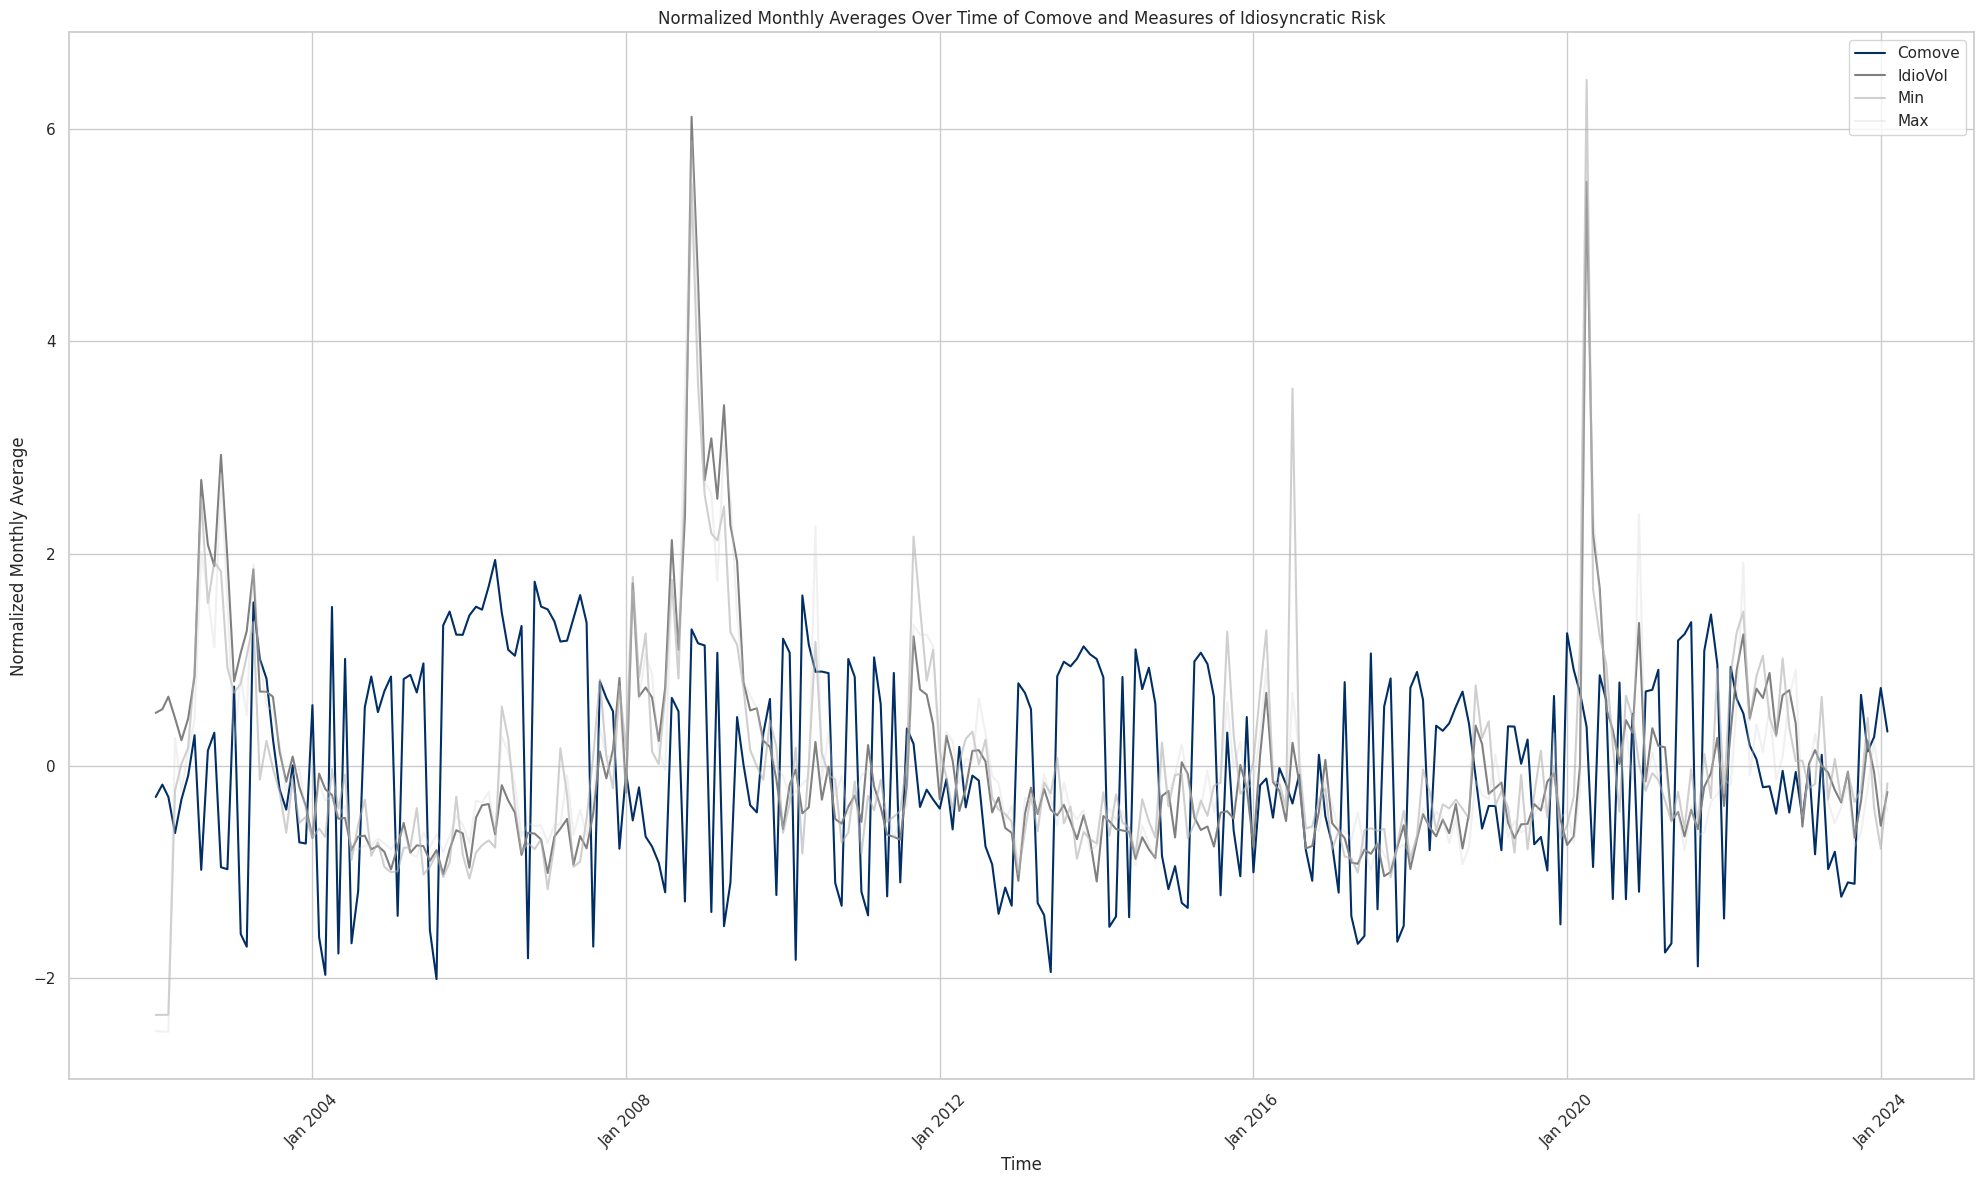

In [111]:
# Define the variables
variables = ['Comove', 'IdioVol', 'Min', 'Max']

# Set the style
sns.set(style="whitegrid")

# Plot normalized monthly averages over time for each variable
plt.figure(figsize=(20, 12))

# Define colors and line styles
# Define colors and line styles
colors = {
    'Comove': '#002E65',  # Blue
    'Beta': '#65A812',  # Green
    'Beta_Downside': '#65A81280',  # Lighter green (transparent)
    'Beta_Upside': '#65A81240',  # Even lighter green (more transparent)
    'LTD': '#65A81280',  # Lighter green (transparent)
    'UTD': '#65A81240',  # Even lighter green (more transparent)
    'IdioVol': '#808080',  # Grey
    'Min': '#B0B0B0',  # Lighter grey
    'Max': '#D0D0D0',  # Even lighter grey
    'Illiquidity': '#006400',  # Dark Green
    'L(Turnover)': '#000000',  # Black
    'Diff in Ln(Turnover)': '#404040'  # Dark grey (almost black)
}

line_styles = {
    'Comove': {'linewidth': 1.5},
    'Beta': {'linewidth': 1.5},
    'Beta_Downside': {'linewidth': 1.5, 'alpha': 0.6},
    'Beta_Upside': {'linewidth': 1.5, 'alpha': 0.3},
    'LTD': {'linewidth': 1.5, 'alpha': 0.6},
    'UTD': {'linewidth': 1.5, 'alpha': 0.3},
    'IdioVol': {'linewidth': 1.5},
    'Min': {'linewidth': 1.5, 'alpha': 0.6},
    'Max': {'linewidth': 1.5, 'alpha': 0.3},
    'Illiquidity': {'linewidth': 1.5},
    'L(Turnover)': {'linewidth': 1.5},
    'Diff in Ln(Turnover)': {'linewidth': 1.5, 'alpha': 0.6}
}

# Plot each variable with specified color and line style
for var in variables:
    plt.plot(normalized_averages.index, normalized_averages[var], label=var, color=colors[var], **line_styles[var])

plt.xlabel('Time')
plt.ylabel('Normalized Monthly Average')
plt.title('Normalized Monthly Averages Over Time of Comove and Measures of Idiosyncratic Risk')
plt.legend()

# Format x-axis as dates
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Ensure the plot has a grid
plt.grid(True)
plt.tight_layout()
plt.savefig('Normalized_Monthly_Averages_Over_Time_2.png')
plt.show()


We can see that Comove has different trends over time, while the measurements do follow each other somehow.

# 2. Regression Analysis

### 2.0 Functions used

In [242]:
def prepare_data(df, independent_vars, dependent_var='Return', add_constant=True):
    # Ensure all necessary columns are present
    missing_columns = [col for col in independent_vars + [dependent_var] if col not in df.columns]
    if missing_columns:
        raise KeyError(f"Missing columns: {missing_columns}")

    # Convert boolean columns to integers
    df[independent_vars] = df[independent_vars].apply(lambda x: x.astype(int) if x.dtype == bool else x)

    # Drop rows with missing values in the relevant columns
    df = df.dropna(subset=independent_vars + [dependent_var])
    df[independent_vars + [dependent_var]] = df[independent_vars + [dependent_var]].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=independent_vars + [dependent_var])  # Ensure all data is numeric

    # Remove rows with inf values
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=independent_vars + [dependent_var])

    # Prepare independent variables: add constant
    X = df[independent_vars]
    if add_constant:
        X = sm.add_constant(X)

    # Prepare dependent variable
    y = df[dependent_var]

    return X, y

In [243]:
def run_regression(X, y):
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    return model, model.rsquared, model.nobs

In [244]:
def calculate_statistics(coefficients_df, residuals_matrix, X_matrix, rsquared_list, nobs_list):
    # Calculate average coefficients
    average_coefficients = coefficients_df.mean()

    # Fit the final model using the stacked data to get robust covariance matrix
    final_model = sm.OLS(residuals_matrix, X_matrix).fit()
    nw_cov = cov_hac(final_model, nlags=1)

    # Calculate Newey-West adjusted standard errors
    nw_se = np.sqrt(np.diag(nw_cov))

    # Calculate t-statistics
    t_stats = average_coefficients / nw_se

    # Calculate p-values for average coefficients
    p_values_avg = pd.Series([2 * (1 - stats.norm.cdf(np.abs(t))) for t in t_stats], index=average_coefficients.index)

    # Add significance stars
    significance = p_values_avg.apply(lambda p: '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.1 else '')))

    # Create result DataFrame
    results = pd.DataFrame({
        'Coefficient': average_coefficients,
        't-Statistic': t_stats,
        'p-Value': p_values_avg,
        'Significance': significance
    })

    # Calculate average R-squared, average N, and T
    avg_rsquared = np.mean(rsquared_list)
    avg_nobs = np.mean(nobs_list)
    T = len(rsquared_list)

    return results, avg_rsquared, avg_nobs, T

In [245]:
def fama_macbeth_regression(dfs, independent_vars, add_constant=True):
    """
    Performs Fama and MacBeth regressions on a dictionary of dataframes.

    Parameters:
    dfs (dict): Dictionary where keys are month-year strings and values are dataframes.
    independent_vars (list): List of strings representing the independent variables.
    add_constant (bool): Whether to add a constant to the regression. Default is True.

    Returns:
    tuple: Tuple containing three DataFrames:
        - results: DataFrame with average coefficients, t-statistics, p-values, and significance stars.
        - coefficients_over_time: DataFrame with coefficients for each month.
        - summary: DataFrame with average R-squared, average N, and T.
    """
    # Suppress warnings
    warnings.filterwarnings('ignore')

    # Initialize list to store coefficients, residuals, R-squared values, and number of observations
    coefficients = []
    residuals = []
    X_matrices = []
    rsquared_list = []
    nobs_list = []
    months = []

    # Loop through each month
    for month, df in dfs.items():
        try:
            X, y = prepare_data(df, independent_vars, add_constant=add_constant)
        except KeyError as e:
            print(f"Skipping month {month} due to missing columns: {e}")
            continue

        if X.empty or y.empty:
            print(f"Skipping month {month} due to empty data after preparation")
            continue

        # Run regression
        model, rsquared, nobs = run_regression(X, y)

        # Store the coefficients, residuals, R-squared values, and number of observations
        coefficients.append(model.params)
        residuals.append(model.resid)
        X_matrices.append(X)
        rsquared_list.append(rsquared)
        nobs_list.append(nobs)
        months.append(month)

    # Convert coefficients to DataFrame
    coefficients_df = pd.DataFrame(coefficients, index=months)

    # Stack residuals and X matrices for Newey-West adjustment
    residuals_matrix = np.hstack([resid.values for resid in residuals])
    X_matrix = np.vstack([X.values for X in X_matrices])

    # Calculate statistics
    results, avg_rsquared, avg_nobs, T = calculate_statistics(coefficients_df, residuals_matrix, X_matrix, rsquared_list, nobs_list)

    # Create summary DataFrame
    summary = pd.DataFrame({
        'Average R-squared': [avg_rsquared],
        'Average N': [avg_nobs],
        'T': [T]
    })

    # Restore warnings
    warnings.filterwarnings('default')

    return results, coefficients_df, summary


### 2.1  Main Variables

#### 2.1.1 Regression results

Let's first preform the needed regression analysis on our main variables: Comove, Beta, Size, Value and Momentum to Return.

In [246]:
# Example usage
# Assuming dfs is a dictionary with your dataframes
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum']
results_main, coefficients_over_time, stats_main = fama_macbeth_regression(dfs, independent_vars, add_constant=True)

print("Results:")
results_main

Results:


,Coefficient,t-Statistic,p-Value,Significance
const,-0.015971,-4.664820,0.000003,***
Comove,0.005894,2.739999,0.006144,***
Beta,-0.002577,-4.636589,0.000004,***
Size,0.001479,8.669620,0.000000,***
Value,-0.000628,-2.310393,0.020866,**
Momentum,0.006932,9.793779,0.000000,***


In [247]:
print("Statistics:")
stats_main

Statistics:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Average R-squared,Average N,T
0,0.114045,547.789474,266



𝑅2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables. An R2 value close to 1 means that a significant portion of the variation in the dependent variable is explained by the independent variables. Conversely, an R2 close to 0 indicates that the model does not explain much of the variance in the dependent variable. In america, 0,657

𝑇 represents the number of time periods or months in your data. In america, 636

Average N is the number of stocks per time period. In america, 1893

so although less observations in time and number of stocks, more variability explained

#### 2.1.2 Coefficients over Time

In [248]:
print("\nCoefficients Over Time:")
coefficients_over_time


Coefficients Over Time:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,const,Comove,Beta,Size,Value,Momentum
012002,0.001543,0.001199,-0.000159,-0.000044,-1.573419e-04,0.067847
022002,0.001097,-0.000971,-0.000137,-0.000006,-4.873112e-05,0.049536
032002,0.001698,-0.000482,0.000192,-0.000067,2.287303e-08,-0.053421
042002,0.190267,-0.125786,-0.074118,0.001120,-1.414602e-02,0.024688
052002,0.037441,-0.003838,-0.041193,0.006024,-1.604305e-02,-0.000624
...,...,...,...,...,...,...
102023,-0.028743,-0.086576,-0.060211,0.006972,-3.500150e-03,0.050477
112023,-0.084599,0.050216,0.088376,0.000490,5.240819e-03,-0.025697
122023,0.069887,-0.031137,0.059511,-0.006058,4.420785e-03,-0.049850
012024,-0.073565,0.095635,-0.043503,0.002312,2.760031e-03,0.044342


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


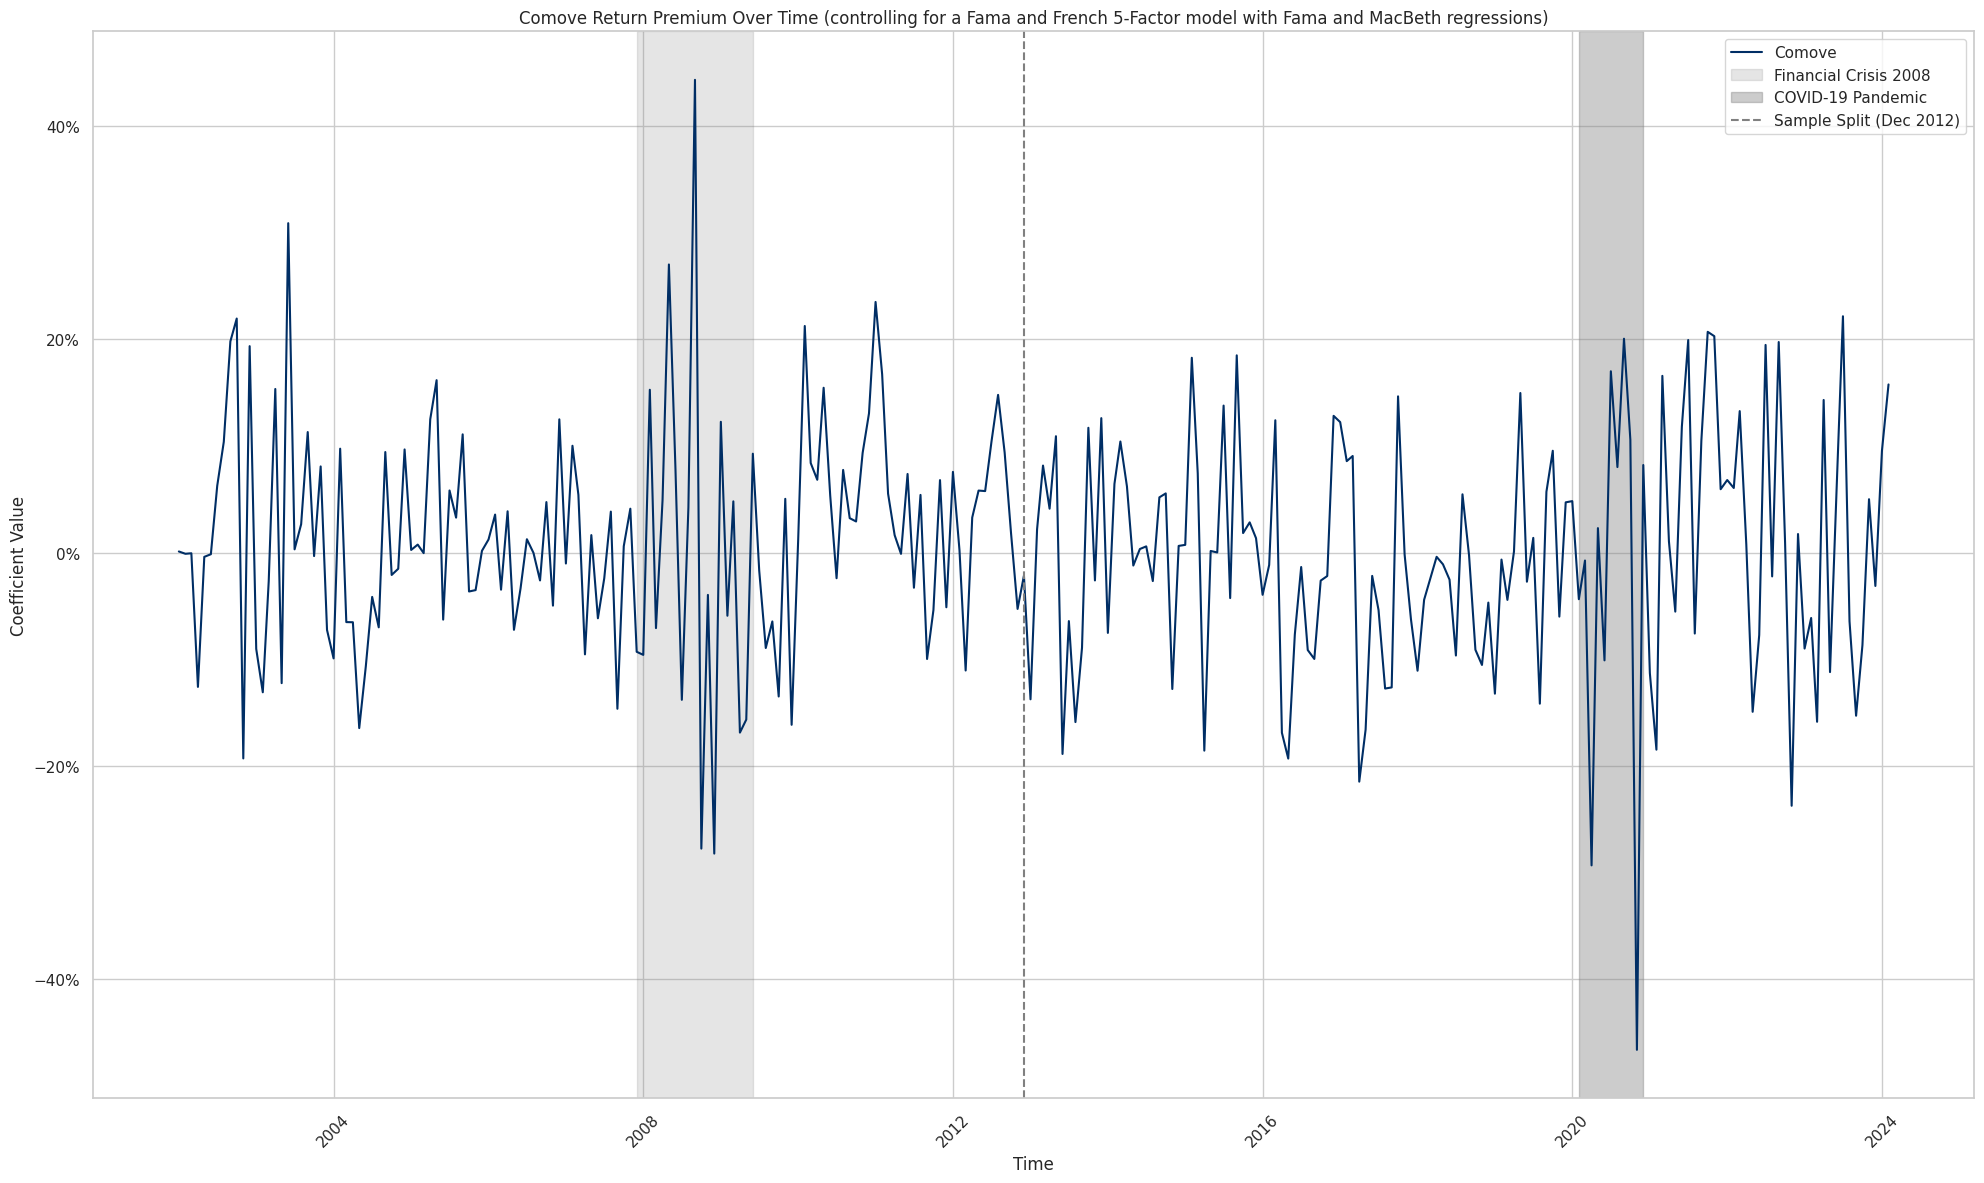

In [249]:
# Convert the MMYYYY to a proper date format for plotting
coefficients_over_time.index = pd.to_datetime(coefficients_over_time.index, format='%m%Y')

# Set the style
sns.set(style="whitegrid")

# Define colors
colors = {1: '#002E65', 2: '#65A812'}  # Map comove ranks to specific colors

# Plotting the 'Comove' coefficient over time
plt.figure(figsize=(20, 12))
plt.plot(coefficients_over_time.index, coefficients_over_time['Comove'], label='Comove', color=colors[1])

# Highlight crisis periods
plt.axvspan('2007-12-01', '2009-06-01', alpha=0.2, label='Financial Crisis 2008', color='grey')  # Financial crisis of 2008
plt.axvspan('2020-02-01', '2020-12-01', alpha=0.4, label='COVID-19 Pandemic', color='grey')  # COVID-19 Pandemic

# Highlight sample split
sample_split_date = pd.to_datetime('2012-12', format='%Y-%m')
plt.axvline(x=sample_split_date, color='grey', linestyle='--', label='Sample Split (Dec 2012)')

plt.xlabel('Time')
plt.ylabel('Coefficient Value')
plt.title('Comove Return Premium Over Time (controlling for a Fama and French 5-Factor model with Fama and MacBeth regressions)')
plt.legend()

# Format x-axis as dates
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.xticks(rotation=45)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.grid(True)
plt.tight_layout()
plt.savefig('Comove_Coefficients_Over_Time.png')
plt.show()

Now we can see that the higher comove return premium in the first half of our sample split is most likely due to extreme high premiums during the financial crisis in the first half and extreme low premium returns during the covid-19 pandemic in the second part of the sample.

### 2.2 Other measurements of dependency and volatility

#### 2.2.1 Assymetric Risk

In [250]:
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum', 'Beta_Downside', 'Beta_Upside']
results_downsideUpside, coefficients_over_time, stats_downsideUpside = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_downsideUpside

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.020426,-5.964978,2.446673e-09,***
Comove,0.007201,3.381036,7.221299e-04,***
Beta,0.002678,1.822470,6.838370e-02,*
Size,0.001674,9.825781,0.000000e+00,***
Value,-0.000621,-2.308688,2.096090e-02,**
Momentum,0.007000,9.901548,0.000000e+00,***
Beta_Downside,-0.002923,-1.902439,5.711380e-02,*
Beta_Upside,-0.003207,-2.648874,8.076054e-03,***


In [251]:
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum', 'UTD', 'LTD']
results_tail, coeff, stats_tail = fama_macbeth_regression(dfs, independent_vars)
results_tail

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.018594,-5.377520,7.551897e-08,***
Comove,0.006209,2.908578,3.630763e-03,***
Beta,-0.001961,-2.513004,1.197081e-02,**
Size,0.001749,10.082038,0.000000e+00,***
Value,-0.000668,-2.476256,1.327685e-02,**
Momentum,0.007466,10.325101,0.000000e+00,***
UTD,-0.044434,-4.065711,4.788630e-05,***
LTD,0.033231,4.011810,6.025503e-05,***


#### 2.2.2 Idiosyncratic Risk

In [252]:
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum', 'IdioVol']
results_idioVol, coefficients_over_time, stats_idioVol = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_idioVol

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.013453,-3.807391,1.404407e-04,***
Comove,0.005839,2.741511,6.115723e-03,***
Beta,-0.002040,-3.688982,2.251534e-04,***
Size,0.001358,7.848285,4.218847e-15,***
Value,-0.000554,-2.053979,3.997777e-02,**
Momentum,0.007545,11.146635,0.000000e+00,***
IdioVol,-0.001318,-2.922875,3.468160e-03,***


In [253]:
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum', 'Min', 'Max']
results_minMax, coefficients_over_time, stats_minMax = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_minMax

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.014200,-4.147368,0.000034,***
Comove,0.004643,2.190026,0.028522,**
Beta,-0.001507,-2.633352,0.008455,***
Size,0.001438,8.526817,0.000000,***
Value,-0.000610,-2.282410,0.022465,**
Momentum,0.007349,10.813297,0.000000,***
Min,-0.025483,-1.827183,0.067672,*
Max,-0.018389,-1.644282,0.100118,


#### 2.2.3 Illiquidity

In [254]:
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum', 'Illiquidity']
results_illiquidity, coefficients_over_time, stats_illiquidity = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_illiquidity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.024905,-6.970835,3.150591e-12,***
Comove,0.008374,3.713194,2.046595e-04,***
Beta,-0.002673,-4.604105,4.142427e-06,***
Size,0.001815,10.115278,0.000000e+00,***
Value,-0.000396,-1.413460,1.575204e-01,
Momentum,0.006148,8.183985,2.220446e-16,***
Illiquidity,482.242746,379.673149,0.000000e+00,***


#### 2.2.4 Trading Activity

In [255]:
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum', 'Ln(Turnover)', 'Diff in Ln(Turnover)']
results_trading, coefficients_over_time, stats_trading = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_trading

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.013371,-3.770082,1.631936e-04,***
Comove,0.005918,2.770463,5.597665e-03,***
Beta,-0.002529,-4.490622,7.101540e-06,***
Size,0.001431,7.756602,8.659740e-15,***
Value,-0.000805,-2.959235,3.084043e-03,***
Momentum,0.007294,10.396943,0.000000e+00,***
Ln(Turnover),-0.000060,-0.505877,6.129426e-01,
Diff in Ln(Turnover),0.000816,1.396641,1.625215e-01,


#### 2.2.5 Summary

In [256]:
# Assuming the results from the regressions are stored in the following variables
results_dict = {
    '4F Baseline': results_main,
    'Assymetric Risk (Downside Upside)': results_downsideUpside,
    'Assymetric Risk (Tail)': results_tail,
    'Idiosyncratic Risk (IdioVol)': results_idioVol,
    'Idiosyncratic Risk (Min Max)': results_minMax,  # Corrected typo here
    'Illiquidity': results_illiquidity,
    'Trading Activity': results_trading,
}

# Statistics for each model
stats_dict = {
    '4F Baseline': stats_main,
    'Assymetric Risk (Downside Upside)': stats_downsideUpside,
    'Assymetric Risk (Tail)': stats_tail,
    'Idiosyncratic Risk (IdioVol)': stats_idioVol,
    'Idiosyncratic Risk (Min Max)': stats_minMax,  # Corrected typo here
    'Illiquidity': stats_illiquidity,
    'Trading Activity': stats_trading,
}

# Initialize a dictionary to store the summary data
summary_data = {
    'Model': [],
    'Comove': [],
    'Beta': [],
    'Size': [],
    'Value': [],
    'Momentum': [],
    'Beta_Downside': [],
    'Beta_Upside': [],
    'UTD': [],
    'LTD': [],
    'IdioVol': [],
    'Min': [],
    'Max': [],
    'Illiquidity': [],
    'Ln(Turnover)': [],
    'Diff in Ln(Turnover)': [],
    'Avg R^2': [],
    'Avg N': [],
    'T': [],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [257]:
# Function to format the coefficients and significance stars
def format_coefficient(coef, star):
    return f"{coef*100:}{star}"

In [258]:
# List of all possible variables
all_variables = ['Comove', 'Beta', 'Size', 'Value', 'Momentum', 'Beta_Downside',
                 'Beta_Upside', 'UTD', 'LTD', 'IdioVol', 'Min', 'Max',
                 'Illiquidity', 'Ln(Turnover)', 'Diff in Ln(Turnover)']

# Populate the summary data
for model_name, result in results_dict.items():
    summary_data['Model'].append(model_name)
    for var in all_variables:
        if var in result.index:
            coef = result.loc[var, 'Coefficient']
            star = result.loc[var, 'Significance']
            summary_data[var].append(format_coefficient(coef, star))
        else:
            summary_data[var].append("")

    # Add statistics to the summary
    summary_data['Avg R^2'].append(f"{stats_dict[model_name].loc[0, 'Average R-squared']:.4f}")
    summary_data['Avg N'].append(f"{stats_dict[model_name].loc[0, 'Average N']:.2f}")
    summary_data['T'].append(f"{int(stats_dict[model_name].loc[0, 'T'])}")

 # Create the summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary DataFrame
summary_df.T
summary_df.set_index('Model', inplace=True)
summary_df = summary_df.T
summary_df

Model,4F Baseline,Assymetric Risk (Downside Upside),Assymetric Risk (Tail),Idiosyncratic Risk (IdioVol),Idiosyncratic Risk (Min Max),Illiquidity,Trading Activity
Comove,0.5893877193260687***,0.7201156310813677***,0.6209362881149866***,0.5839292753058489***,0.46430685244779524**,0.8373694351727425***,0.5918229604304672***
Beta,-0.25774864275443654***,0.2677728846811278*,-0.19606743659921155**,-0.2039680601690246***,-0.15072123114996616***,-0.2673331091702174***,-0.2528754402324649***
Size,0.14790236833619458***,0.1674176831893462***,0.17486172547158893***,0.1357875954919079***,0.1438306753928879***,0.18149651935988934***,0.14312693503483223***
Value,-0.06275748346585466**,-0.062080455568872005**,-0.06682088702619665**,-0.055355203449392355**,-0.06097487442396397**,-0.03959143749716567,-0.08046988148488425***
Momentum,0.6931822080436345***,0.7000207523858699***,0.7466307520151951***,0.7544771424073038***,0.7348883687143999***,0.6147544112102223***,0.7294071072976002***
Beta_Downside,,-0.2923273091035477*,,,,,
Beta_Upside,,-0.3207367871907344***,,,,,
UTD,,,-4.44339400414481***,,,,
LTD,,,3.323079666319626***,,,,
IdioVol,,,,-0.13182820538927312***,,,


All really singnificant, for assymetric risk comove premium even becomes larger. For the rest not much of a difference. Rest all around 0.6, except for minmax 0.46 but also less singnificant.

### 2.3 Other Benchmarks, Fixed Effects and Skipped Month

#### 2.3.1 Other Benchmarks

In [259]:
# TODO Nakijken waarom die maanden die kolom niet hebben?
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum_ST', 'Momentum_MT', 'Momentum_LT']
results_momentums, coefficients_over_time, stats_momentums = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_momentums

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Skipping month 052002 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 082002 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 102003 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 012004 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 042004 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 122004 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 092005 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 062006 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 022007 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 112007 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 102008 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 012009 due to missing columns: "Missing columns: ['Momentum_ST']"
Skipping month 072009 due to

,Coefficient,t-Statistic,p-Value,Significance
const,-0.010849,-2.997670,2.720521e-03,***
Comove,0.000717,0.313689,7.537575e-01,
Beta,-0.001513,-2.550779,1.074823e-02,**
Size,0.001320,7.302279,2.828848e-13,***
Value,-0.000738,-2.580789,9.857489e-03,***
Momentum_ST,-0.017416,-4.551985,5.314202e-06,***
Momentum_MT,0.003096,3.638201,2.745492e-04,***
Momentum_LT,0.001898,4.515241,6.324489e-06,***


In [260]:
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Profitability', 'Investment']
results_5F, coefficients_over_time, stats_5F = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_5F

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-3.138879e-02,-7.627170,2.398082e-14,***
Comove,1.530881e-02,7.266824,3.679279e-13,***
Beta,-7.892089e-04,-1.403344,1.605143e-01,
Size,2.119550e-03,8.837755,0.000000e+00,***
Value,-5.714430e-04,-2.068675,3.857664e-02,**
Profitability,-4.299786e-10,-5.700943,1.191462e-08,***
Investment,6.471667e-03,112.042223,0.000000e+00,***


#### 2.3.2 Fixed Effects

In [261]:
# Assuming 'df' is your DataFrame
fixedEffects = [col for col in dfs["012002"].columns if col.startswith("Industry_") or col.startswith("Exchange_") or col.startswith("Size_")] # Just take the first, all the same columns
independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum'] + fixedEffects
results_fixedEffects, coefficients_over_time, stats_fixedEffects = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_fixedEffects

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.021604,-4.759338,1.942290e-06,***
Comove,0.002663,1.635033,1.020422e-01,
Beta,-0.003061,-5.668975,1.436544e-08,***
Size,0.002762,7.621689,2.509104e-14,***
Value,-0.001258,-4.417210,9.998315e-06,***
...,...,...,...,...
Size_1,-0.004712,-7.318663,2.504663e-13,***
Size_2,-0.002277,-3.009623,2.615721e-03,***
Size_3,-0.003162,-3.469241,5.219313e-04,***
Size_4,-0.004139,-3.745066,1.803462e-04,***


#### 2.3.3 Comove with Skipped Month

In [262]:
independent_vars = ['Comove_skippedMonth', 'Beta', 'Size', 'Value', 'Momentum']
results_skippedMonth, coefficients_over_time, stats_skippedMonth = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_skippedMonth

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.016123,-4.711100,2.463829e-06,***
Comove_skippedMonth,0.000054,2.596540,9.416790e-03,***
Beta,-0.002560,-4.605699,4.110820e-06,***
Size,0.001486,8.709580,0.000000e+00,***
Value,-0.000599,-2.204162,2.751294e-02,**
Momentum,0.005014,7.098094,1.264988e-12,***


#### 2.3.4 Summary

In [263]:
# Assuming the results from the regressions are stored in the following variables
results2_dict = {
    '4F with momentums': results_momentums,
    '5F': results_5F,
    'Fixed Effects': results_fixedEffects,
    '4F with Comove skipped month': results_skippedMonth,
}

# Statistics for each model
stats2_dict = {
    '4F with momentums': stats_momentums,
    '5F': stats_5F,
    'Fixed Effects': stats_fixedEffects,
    '4F with Comove skipped month': stats_skippedMonth,
}

# Initialize a dictionary to store the summary data
summary2_data = {
    'Model': [],
    'Comove': [],
    'Comove_skippedMonth': [],
    'Beta': [],
    'Size': [],
    'Value': [],
    'Momentum': [],
    'Momentum_ST': [],
    'Momentum_MT': [],
    'Momentum_LT': [],
    'FixedEffects': [],
    'Profitability': [],
    'Investment': [],
    'Avg R^2': [],
    'Avg N': [],
    'T': [],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [264]:
# List of all possible variables
all_variables2 = ['Comove', 'Comove_skippedMonth', 'Beta', 'Size', 'Value',
                 'Momentum', 'Momentum_ST', 'Momentum_MT', 'Momentum_LT',
                 'FixedEffects', 'Profitability', 'Investment']

# Populate the summary data
for model_name, result in results2_dict.items():
    summary2_data['Model'].append(model_name)
    for var in all_variables2:
        if var in result.index:
            coef = result.loc[var, 'Coefficient']
            star = result.loc[var, 'Significance']
            summary2_data[var].append(format_coefficient(coef, star))
        else:
            summary2_data[var].append("")

    # Add statistics to the summary
    summary2_data['Avg R^2'].append(f"{stats2_dict[model_name].loc[0, 'Average R-squared']:.4f}")
    summary2_data['Avg N'].append(f"{stats2_dict[model_name].loc[0, 'Average N']:.2f}")
    summary2_data['T'].append(f"{int(stats2_dict[model_name].loc[0, 'T'])}")

# Create the summary DataFrame
summary2_df = pd.DataFrame(summary2_data)

# Display the summary DataFrame
summary2_df.T
summary2_df.set_index('Model', inplace=True)
summary2_df = summary2_df.T
summary2_df

Model,4F with momentums,5F,Fixed Effects,4F with Comove skipped month
Comove,0.07173196017839285,1.5308811062114058***,0.2662580732802028,
Comove_skippedMonth,,,,0.005409690779400153***
Beta,-0.15126793873428204**,-0.07892088997088445,-0.30611852123147415***,-0.2559709169586668***
Size,0.13203168108205796***,0.21195504986584154***,0.27619444561210726***,0.1485528590540068***
Value,-0.07376318831328098***,-0.05714430152520159**,-0.12580192583882227***,-0.05985560377417828**
Momentum,,,0.34521531052634896***,0.5014283569454979***
Momentum_ST,-1.741624257213583***,,,
Momentum_MT,0.3096079340537258***,,,
Momentum_LT,0.18983882528171234***,,,
FixedEffects,,,,


### 2.4 Varying the Comove measure and the Sample

#### 2.4.1 Varying the Comove Measure

In [265]:
independent_vars = ['Comove_Monthly', 'Beta', 'Size', 'Value', 'Momentum']
results_monthly, coefficients_over_time, stats_monthly = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_monthly

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.011327,-3.104869,1.903630e-03,***
Comove_Monthly,-0.000042,-1.803776,7.126638e-02,*
Beta,-0.002645,-4.779727,1.755338e-06,***
Size,0.001523,8.962085,0.000000e+00,***
Value,-0.000669,-2.409586,1.597061e-02,**
Momentum,0.005465,7.573184,3.641532e-14,***


In [266]:
independent_vars = ['Comove_Daily', 'Beta', 'Size', 'Value', 'Momentum']
results_daily, coefficients_over_time, stats_daily  = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_daily

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.016174,-4.210280,0.000026,***
Comove_Daily,0.000018,0.413539,0.679212,
Beta,-0.002444,-3.374260,0.000740,***
Size,0.001622,9.358752,0.000000,***
Value,-0.000687,-2.539887,0.011089,**
Momentum,0.006258,8.605283,0.000000,***


In [267]:
independent_vars = ['Comove_EUR50', 'Beta', 'Size', 'Value', 'Momentum']
warnings.filterwarnings('ignore')
results_eur50, coefficients_over_time, stats_eur50 = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_eur50

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Coefficient,t-Statistic,p-Value,Significance
const,-0.016495,-4.805491,0.000002,***
Comove_EUR50,0.000069,3.276210,0.001052,***
Beta,-0.002577,-4.636066,0.000004,***
Size,0.001479,8.669441,0.000000,***
Value,-0.000628,-2.310559,0.020857,**
Momentum,0.006932,9.849067,0.000000,***


#### 2.4.2 Varying the Sample

In [268]:
# For the excluded sample
# Open the Excel workbook
wb_excl = openpyxl.load_workbook('DataExcl_Monthly.xlsx', data_only=True)

# Dictionary to hold the monthly dataframes
dfs_excl = {}

# Define the start and end dates
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)  # DEBUG

# Generate the monthly periods
monthly_periods = pd.date_range(start_date, end_date, freq='M')

for period in monthly_periods:
    # Extract the year and month
    year = period.year
    month = period.month

    # Format the worksheet name as MMYYYY
    df_name = f"{month:02d}{year}"

    # Find the correct worksheet
    try:
        ws = wb_excl[df_name]

        # Read worksheet into a DataFrame
        data = ws.values
        columns = next(data)[0:]  # Get the first row as column names
        df = pd.DataFrame(data, columns=columns)

        df['Comove'] = df['Comove']/ 100 #kwni of da moet
        df['Min'] = df['Min'] * -1

        # Store the DataFrame in the dictionary
        dfs_excl[df_name] = df

    except KeyError:
        print(f"Worksheet {df_name} not found in the workbook.")
    except Exception as e:
        print(f"Failed to read worksheet {df_name}: {e}")

# No need to explicitly close the workbook

independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum']
results_excl, coefficients_over_time, stats_excl = fama_macbeth_regression(dfs, independent_vars, add_constant=True)
results_excl

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Worksheet 032024 not found in the workbook.


,Coefficient,t-Statistic,p-Value,Significance
const,-0.015971,-4.664820,0.000003,***
Comove,0.005894,2.739999,0.006144,***
Beta,-0.002577,-4.636589,0.000004,***
Size,0.001479,8.669620,0.000000,***
Value,-0.000628,-2.310393,0.020866,**
Momentum,0.006932,9.793779,0.000000,***


In [269]:
# Define the date range
start_date = datetime.strptime("012002", "%m%Y")
end_date = datetime.strptime("122012", "%m%Y")

# Filter the dictionary keys
filtered_dfs = {k: v for k, v in dfs.items() if start_date <= datetime.strptime(k, "%m%Y") <= end_date}

# Check the filtered keys
print("Filtered keys:", filtered_dfs.keys())

independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum']
results_firstHalf, coefficients_over_time, stats_firstHalf = fama_macbeth_regression(filtered_dfs, independent_vars, add_constant=True)
results_firstHalf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Filtered keys: dict_keys(['012002', '022002', '032002', '042002', '052002', '062002', '072002', '082002', '092002', '102002', '112002', '122002', '012003', '022003', '032003', '042003', '052003', '062003', '072003', '082003', '092003', '102003', '112003', '122003', '012004', '022004', '032004', '042004', '052004', '062004', '072004', '082004', '092004', '102004', '112004', '122004', '012005', '022005', '032005', '042005', '052005', '062005', '072005', '082005', '092005', '102005', '112005', '122005', '012006', '022006', '032006', '042006', '052006', '062006', '072006', '082006', '092006', '102006', '112006', '122006', '012007', '022007', '032007', '042007', '052007', '062007', '072007', '082007', '092007', '102007', '112007', '122007', '012008', '022008', '032008', '042008', '052008', '062008', '072008', '082008', '092008', '102008', '112008', '122008', '012009', '022009', '032009', '042009', '052009', '062009', '072009', '082009', '092009', '102009', '112009', '122009', '012010', '022

,Coefficient,t-Statistic,p-Value,Significance
const,-0.009521,-1.773641,7.612250e-02,*
Comove,0.014785,4.350950,1.355490e-05,***
Beta,-0.004612,-5.691817,1.256944e-08,***
Size,0.001019,3.884464,1.025559e-04,***
Value,-0.001126,-2.371783,1.770249e-02,**
Momentum,0.003069,2.988411,2.804319e-03,***


In [270]:
# Define the date range
start_date = datetime.strptime("012013", "%m%Y")
end_date = datetime.strptime("032024", "%m%Y")

# Filter the dictionary keys
filtered_dfs = {k: v for k, v in dfs.items() if start_date <= datetime.strptime(k, "%m%Y") <= end_date}

# Check the filtered keys
print("Filtered keys:", filtered_dfs.keys())

independent_vars = ['Comove', 'Beta', 'Size', 'Value', 'Momentum']
results_secondHalf, coefficients_over_time, stats_secondHalf = fama_macbeth_regression(filtered_dfs, independent_vars, add_constant=True)
results_secondHalf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Filtered keys: dict_keys(['012013', '022013', '032013', '042013', '052013', '062013', '072013', '082013', '092013', '102013', '112013', '122013', '012014', '022014', '032014', '042014', '052014', '062014', '072014', '082014', '092014', '102014', '112014', '122014', '012015', '022015', '032015', '042015', '052015', '062015', '072015', '082015', '092015', '102015', '112015', '122015', '012016', '022016', '032016', '042016', '052016', '062016', '072016', '082016', '092016', '102016', '112016', '122016', '012017', '022017', '032017', '042017', '052017', '062017', '072017', '082017', '092017', '102017', '112017', '122017', '012018', '022018', '032018', '042018', '052018', '062018', '072018', '082018', '092018', '102018', '112018', '122018', '012019', '022019', '032019', '042019', '052019', '062019', '072019', '082019', '092019', '102019', '112019', '122019', '012020', '022020', '032020', '042020', '052020', '062020', '072020', '082020', '092020', '102020', '112020', '122020', '012021', '022

,Coefficient,t-Statistic,p-Value,Significance
const,-0.022324,-4.871662,0.000001,***
Comove,-0.002864,-1.062473,0.288021,
Beta,-0.000573,-0.738516,0.460201,
Size,0.001932,8.612528,0.000000,***
Value,-0.000136,-0.417459,0.676342,
Momentum,0.010737,11.276166,0.000000,***


hmm mss toch niet door crissisen? toch verwarrend he

#### 2.4.3 Summary

In [271]:
# Assuming the results from the regressions are stored in the following variables
results3_dict = {
    '4F with Comove Monthly': results_monthly,
    '4F with Comove Daily': results_daily,
    '4F with EUR50': results_eur50,
    '4F with Excluding Small size, price & LN': results_excl,
    '4F with Sample Split: Jan 2002 - Dec 2012': results_firstHalf,
    '4F with Sample Split: Jan 2013 - Feb 2023': results_secondHalf,
}

# Assuming the statistics from the regressions are stored in the following variables
stats3_dict = {
    '4F with Comove Monthly': stats_monthly,
    '4F with Comove Daily': stats_daily,
    '4F with EUR50': stats_eur50,
    '4F with Excluding Small size, price & LN': stats_excl,
    '4F with Sample Split: Jan 2002 - Dec 2012': stats_firstHalf,
    '4F with Sample Split: Jan 2013 - Feb 2023': stats_secondHalf,
}

# Initialize a dictionary to store the summary data
summary3_data = {
    'Model': [],
    'Comove': [],
    'Comove_Monthly': [],
    'Comove_Daily': [],
    'Comove_EUR50': [],
    'Beta': [],
    'Size': [],
    'Value': [],
    'Momentum': [],
    'Avg R^2': [],
    'Avg N': [],
    'T': [],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [272]:
# List of all possible variables
all_variables3 = ['Comove', 'Comove_Monthly', 'Comove_Daily', 'Comove_EUR50',
                  'Beta', 'Size', 'Value', 'Momentum']



# Populate the summary data
for model_name, result in results3_dict.items():
    summary3_data['Model'].append(model_name)
    for var in all_variables3:
        if var in result.index:
            coef = result.loc[var, 'Coefficient']
            star = result.loc[var, 'Significance']
            summary3_data[var].append(format_coefficient(coef, star))
        else:
            summary3_data[var].append("")

    # Add statistics to the summary
    summary3_data['Avg R^2'].append(f"{stats3_dict[model_name].loc[0, 'Average R-squared']:.4f}")
    summary3_data['Avg N'].append(f"{stats3_dict[model_name].loc[0, 'Average N']:.2f}")
    summary3_data['T'].append(f"{int(stats3_dict[model_name].loc[0, 'T'])}")

# Create the summary DataFrame
summary_df3 = pd.DataFrame(summary3_data)

# Display the summary DataFrame
summary_df3.set_index('Model', inplace=True)
summary_df3 = summary_df3.T
summary_df3

Model,4F with Comove Monthly,4F with Comove Daily,4F with EUR50,"4F with Excluding Small size, price & LN",4F with Sample Split: Jan 2002 - Dec 2012,4F with Sample Split: Jan 2013 - Feb 2023
Comove,,,,0.5893877193260687***,1.4784710204219034***,-0.28642568175341
Comove_Monthly,-0.004152764548492031*,,,,,
Comove_Daily,,0.0017728261405673773,,,,
Comove_EUR50,,,0.006942618487093682***,,,
Beta,-0.26450034126545435***,-0.24437438448443147***,-0.2577486427544372***,-0.25774864275443654***,-0.461202550682973***,-0.0573313603173709
Size,0.152262036108684***,0.16216990958299043***,0.14790236833619458***,0.14790236833619458***,0.1019059902642273***,0.19321223330261006***
Value,-0.06686020758568717**,-0.06873986543549686**,-0.06275748346585466**,-0.06275748346585466**,-0.11261975618155**,-0.013639423775766676
Momentum,0.5464828881812959***,0.6258495514203214***,0.6931822080436326***,0.6931822080436345***,0.3068623674902***,1.0737360808276148***
Avg R^2,0.1146,0.1161,0.1140,0.1140,0.1140,0.1141
Avg N,547.36,547.79,547.79,547.79,514.53,580.55


# 3. Writing to Excel

In [275]:
# Dictionary to store the dataframes with their names
resultsFinal_dict = {
    'MeasuresDependency': summary_df,
    'BenchhmarksFixedSkipped': summary2_df,
    'VaryingComoveMeasureSampe': summary_df3,
}

# Create a Pandas Excel writer using openpyxl as the engine
with pd.ExcelWriter('Results_Monthly.xlsx', engine='openpyxl') as writer:
    for sheet_name, df in resultsFinal_dict.items():
        df.to_excel(writer, sheet_name=sheet_name)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
